## 07/03/2021 

Variational autoencoders are very similar to the autoencoder, in the sense that it also tries to compress the input into a small latent space. 

The way this is done is very similiar to the autoencoder, where convoluional filters can be applied to the input and squeeze its dimensions down gradually. However, the bottleneck layer in the middle of the variational autoencoder has the ability to sample its latent variables, which is a very desirable characteristic. 

This allows the network to guard against overfitting by increasing the amount of apparent training data available. 

In [2]:
import torch 
import json 
import numpy as np 
from sklearn.model_selection import train_test_split 
from torch.utils.data import SubsetRandomSampler, DataLoader,TensorDataset
from torch.autograd import Variable 

from tqdm import tqdm 
import torch.nn.functional as F
from torch import nn


## 07/03/2021 

To proceed, can generate the dataset loaders again, moving the computation to the gpu. 

define a few more model paths, as the network is no longer a simple single network design.

The variational autoencoder needs to have its encoding network and decoding networks separate, this is because of the sampling layer in the middle requiring separate training. 

In [3]:
DATA_PATH = "./data/synthetic/train_data.json"
TEST_PATH = "./data/synthetic/test_data.json"
EPOCHS = 300
BATCH_SIZE = 150
SAVED_MODEL_PATH_E = "./models/model_vaeE.pth"
SAVED_MODEL_PATH_D = "./models/model_vaeD.pth"
SAVED_MODEL_PATH_G = "./models/model_vaeG.pth"

In [4]:
def load_dataset(data_path):
    with open(data_path,"r") as fp: 
        data = json.load(fp)
    X = np.array(data["data"])
    y = np.array(data["labels"])
    return X, y 

def to_device(data,device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device)for x in data]
    else:
        return data.to(device, non_blocking = True)
    
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl 
        self.device = device 
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)
    
    
X,y=load_dataset(DATA_PATH)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()
dataset = TensorDataset(X,y)
X_test, y_test = load_dataset(TEST_PATH)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
testset = TensorDataset(X_test,y_test)

train_dl = DataLoader(dataset, BATCH_SIZE, shuffle = True, drop_last=True)
test_dl = DataLoader(testset, BATCH_SIZE, shuffle = True, drop_last=True)

input_shape = dataset[0][0].shape
device = torch.device('cuda')
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [5]:
print(testset[0][0].shape)
print(type(dataset[0][0]))

torch.Size([1, 128, 16])
<class 'torch.Tensor'>


## 07/03/2021 

The variational autoencoder would have 2 networks, an encoder and a decoder. 

each of these networks must inherit form the nn.Module base class. 

The forward methods in the networks now contains only the layers of the sub-netowrk. 

For the encoder this is a number of convolution layers followed by leaky relu layers, before flattening. 

An additional reparameterise function was written, to take a sample from the distributions. this is done by std.data.new

needs to converted into a sample using the Varible function. 

if not in training mode, the reparameterise function would just do nothing, because during operation we do not want to draw samples, so just grab the mean. 

The decoder network contains deconvolution layers folled by relu. 

A few concrete examples of these encoder / decoder classes are made 

In [7]:
latent_size = 9
# https://towardsdatascience.com/convolutional-autoencoders-for-image-noise-reduction-32fce9fc1763

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,stride = 2, padding=1 , kernel_size=3)
        self.relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(32,64, stride = 2, padding =1, kernel_size=3)
        self.conv3 = nn.Conv2d(64,128,stride =2, padding =1, kernel_size = 3)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(4096,latent_size)

    
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.conv3(out)        
        out = self.relu(out)
        out = self.flatten(out)
        out1 = self.relu(self.linear(out))
        out2 = self.relu(self.linear(out))
        
        return out1, out2
    
def reparameterise(mu, log_var, training_mode):
    if training_mode:
        std = torch.exp(0.5*log_var)
        eps = Variable(std.data.new(std.size()).normal_())
        sample = mu + (eps*std)
        return sample 
    else:
        return mu 
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(latent_size,4096)
        self.relu = nn.LeakyReLU(0.2)

        self.deconv3 = nn.ConvTranspose2d(128,64,stride =2, kernel_size = 3, padding =1,output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64,32,stride =2, kernel_size = 3,padding =1,output_padding=1)
        self.deconv1 = nn.ConvTranspose2d(32,1,stride =2, kernel_size = 3,padding =1,output_padding=1)
        
    def forward(self, xb):
        out = self.fc(xb)
        out = self.relu(out)
        out = out.reshape(-1,128,16,2)
        out = self.deconv3(out)
        out = self.relu(out)
        out = self.deconv2(out)
        out = self.relu(out)
        out = self.deconv1(out)
        return out

E_module = Encoder()
G_module = Decoder()
D_module = Decoder()

E_module.to(device)
G_module.to(device)
D_module.to(device)
E_module.load_state_dict(torch.load(SAVED_MODEL_PATH_E))
G_module.load_state_dict(torch.load(SAVED_MODEL_PATH_G))
D_module.load_state_dict(torch.load(SAVED_MODEL_PATH_D))

<All keys matched successfully>

In [8]:
from torchsummary import summary 
print(summary(E_module, input_size = (1,128,16)))
print(summary(G_module, input_size = (1,9)))
print(summary(D_module, input_size = (1,9)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 32, 64, 8]             320
         LeakyReLU-2            [-1, 32, 64, 8]               0
            Conv2d-3            [-1, 64, 32, 4]          18,496
         LeakyReLU-4            [-1, 64, 32, 4]               0
            Conv2d-5           [-1, 128, 16, 2]          73,856
         LeakyReLU-6           [-1, 128, 16, 2]               0
           Flatten-7                 [-1, 4096]               0
            Linear-8                    [-1, 9]          36,873
         LeakyReLU-9                    [-1, 9]               0
           Linear-10                    [-1, 9]          36,873
        LeakyReLU-11                    [-1, 9]               0
Total params: 166,418
Trainable params: 166,418
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

In [48]:

for images, labels in test_dl: 
    print("spectrogram shape: ", images.shape)
    out, _ = E_module(images)
    
    print("output shape: ", out.shape)
    break 
    
img = out.detach().cpu()
print(img.shape)
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(1,1,figsize = (5,5))
ax.imshow(img.T, aspect = 'auto')


spectrogram shape:  torch.Size([150, 1, 128, 16])
output shape:  torch.Size([150, 9])


KeyboardInterrupt: 

## 09/03/2021 

as before, would like to visualise the various aspects of the variational autoencoder network, including the model structure, the input spectrogram. 

The loss function is no longer a simple mse. 

This is because additional constraints must be put in place to restrict the distributions learnt by the vae. without these extra terms in the objective function, the training will allow any arbitrary mean/variance to be learnt on the latent variable distributions, and this is not very useful because we cannot then effectively draw from the distribution. Instead, we include the kullback leiber distance (KLD) between the learnt distributions and the unit normal distribution. 

Training to have this minimised will result in the learnt distributions all being close to a standard normal. 

In [49]:



def loss_function(images, reconstructed, mu,logvar):
    mse = nn.MSELoss()
    mse_loss = mse(images,reconstructed)
    
    KLD = -0.5*torch.sum(1+logvar - mu.pow(2) - logvar.exp())
    KLD /= BATCH_SIZE * 128*16
    return KLD+mse_loss



## Now start training and see what the resulting image would look like 


In [13]:
e_opt= torch.optim.Adam(E_module.parameters(), lr = 0.0002)
d_opt= torch.optim.Adam(D_module.parameters(), lr = 0.0002)
g_opt= torch.optim.Adam(G_module.parameters(), lr = 0.0002)





In [91]:
loss_list = []
EPOCHS = 40
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_dl):
        mu, logvar = E_module(images)
        z = reparameterise(mu, logvar, True)
        
        reconstructed = G_module(z)
        
        
        loss = loss_function(images, reconstructed, mu, logvar)
        
        e_opt.zero_grad()
        g_opt.zero_grad()
        loss.backward()
        e_opt.step()
        g_opt.step()
    
    loss_list.append(np.sum(loss.item()))
    
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, EPOCHS, loss.item()))

        


epoch [1/40], loss:26.9905
epoch [2/40], loss:26.5099
epoch [3/40], loss:26.4125
epoch [4/40], loss:26.4611
epoch [5/40], loss:26.3395
epoch [6/40], loss:26.5293
epoch [7/40], loss:26.7368
epoch [8/40], loss:26.4846


KeyboardInterrupt: 

In [86]:
torch.save(E_module.state_dict(), SAVED_MODEL_PATH_E)
torch.save(D_module.state_dict(), SAVED_MODEL_PATH_D)
torch.save(G_module.state_dict(), SAVED_MODEL_PATH_G)

## 09/03/2021

The training process for the vae was more difficult. This is expected as the model has an extra layer of complexity. 

The training was done for the same number of epochs as before and the model parameters have been saved. 

Note that if the model parameters are to be used again, a fresh network with the exact same architecture must first be created. 

The reconstruction characteristics are shown as well, it is difficult to see the difference between the reconstruction from vae compared with the standard ae. need to plot out the auc curves

spectrogram shape:  torch.Size([150, 1, 128, 16])
output shape:  torch.Size([150, 1, 128, 16])
torch.Size([128, 16])


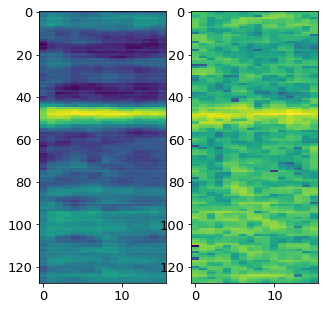

In [50]:

for images, labels in train_dl: 
    print("spectrogram shape: ", images.shape)
    mu, logvar = E_module(images)
    z = reparameterise(mu, logvar, False)

    out = G_module(z)    
    print("output shape: ", out.shape)
    break 
    
img = out[1][0].detach().cpu()
print(img.shape) 
import matplotlib.pyplot as plt 
fig, axs = plt.subplots(1,2,figsize = (5,5))
axs[0].imshow(img, aspect = 'auto')
axs[1].imshow(images[1][0].detach().cpu(), aspect = 'auto')

In [51]:
out_list = [[] for i in range(3)]
imgs = [[] for i in range(3)]
mse_per_image = nn.MSELoss(reduction='none')
for images, labels in test_dl:
    print(images.shape)
    mu, logvar = E_module(images)
    z = reparameterise(mu, logvar, False) 
    out = G_module(z)    
    losses = torch.mean(mse_per_image(images, out).detach().cpu(), dim =(1,2,3))
    losses = losses.numpy()
    for i in range(len(images)):
        out_list[int(labels[i].detach().cpu())].append(losses[i])
        imgs[int(labels[i].detach().cpu())].append(images[i])


torch.Size([150, 1, 128, 16])
torch.Size([150, 1, 128, 16])
torch.Size([150, 1, 128, 16])
torch.Size([150, 1, 128, 16])


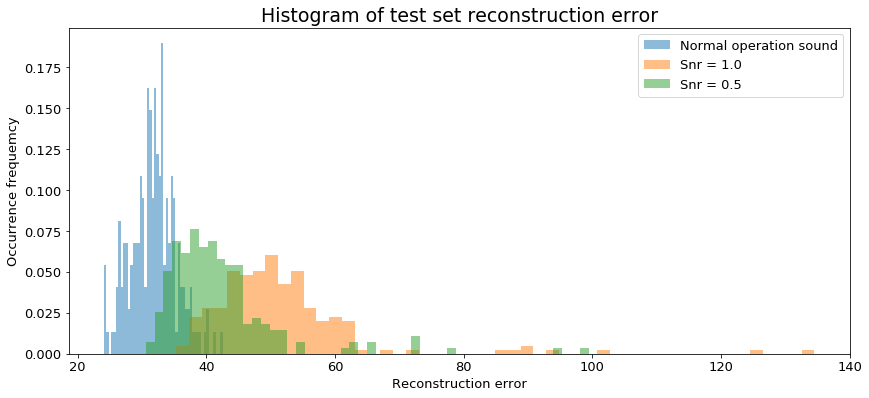

torch.Size([1, 128, 16])


In [52]:

fig, ax = plt.subplots(1,1,figsize = (14,6))

ax.title.set_text("Histogram of test set reconstruction error")
ax.title.set_fontsize(19)
labels = ["Normal operation sound", "Snr = 1.0", "Snr = 0.5"]

for i in range(len(out_list)):
    ax.hist(bins = 50, x=out_list[i], alpha = 0.5, label = labels[i], density = True)

ax.set_xlabel("Reconstruction error")
ax.set_ylabel("Occurrence frequemcy")
ax.legend()
plt.show()

min_img = imgs[1][out_list[1].index(min(out_list[1]))]
print(np.shape(min_img))


torch.Size([1, 128, 16])
torch.Size([128, 16])


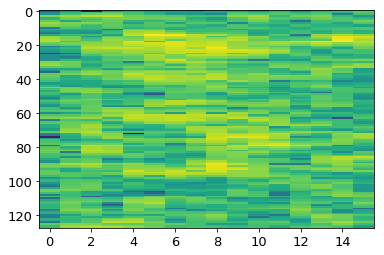

In [53]:
min_img = imgs[1][out_list[1].index(min(out_list[1]))]
print(np.shape(min_img))
im = min_img.detach().cpu().squeeze()
print(np.shape(im))
plt.imshow(im, aspect = "auto")

The difference is 0.07434351656474206


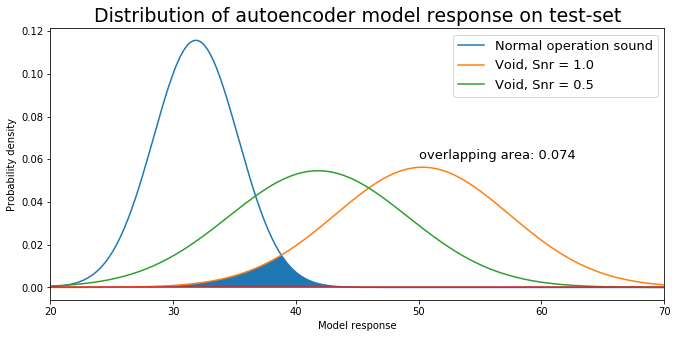

In [19]:
import scipy.integrate
from scipy.stats import norm
fig, ax = plt.subplots(1,1,figsize = (11,5))
integrate = scipy.integrate.quad
ax.title.set_text("Distribution of autoencoder model response on test-set")
ax.title.set_fontsize(19)
labels = ["Normal operation sound", "Void, Snr = 1.0", "Void, Snr = 0.5"]
x = np.linspace(20,140,800)
SMALL_SIZE = 13
MEDIUM_SIZE = 13
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
 
for i in range(len(out_list)):
    truncated = [out_list[i][j] if out_list[i][j]<=65 else 65 for j in range(len(out_list[i]))]
    if i ==1: 
        m_old = m
        s_old = s
        y_old = y
    m = np.mean(truncated)
    s = np.sqrt(np.var(truncated))
    y = norm.pdf(x,m,s)

    if i==1:
        under_fun = lambda x: min(norm.pdf(x,m,s), norm.pdf(x,m_old, s_old))
        diff = integrate(under_fun, 10,60)
        print(f"The difference is {diff[0]}")
        y_min = [min(y[i],y_old[i]) for i in range(len(y))]
        ax.fill_between(x, y_min)
    ax.plot(x,y, label = labels[i])
    


ax.plot(x, [0 for i in range(len(x))])
ax.set_xlim([20,70])
ax.set_xlabel("Model response")
ax.set_ylabel("Probability density")
ax.text(50,0.06,f"overlapping area: {diff[0]:.3f}")
ax.legend()
plt.show()


## 11/03/2021 


The roc curve of the vae was calculated. The auc should be calculated as before and the results should indicate whether this model is able to achieve a better performance. 

The model achieves an auc of 0.997, this is indeed better than the basic autoencoder and the pricniple conmponent analysis based detector.

The aoc score is 0.997 for snr =1
The aoc score is 0.938 for snr =0.5


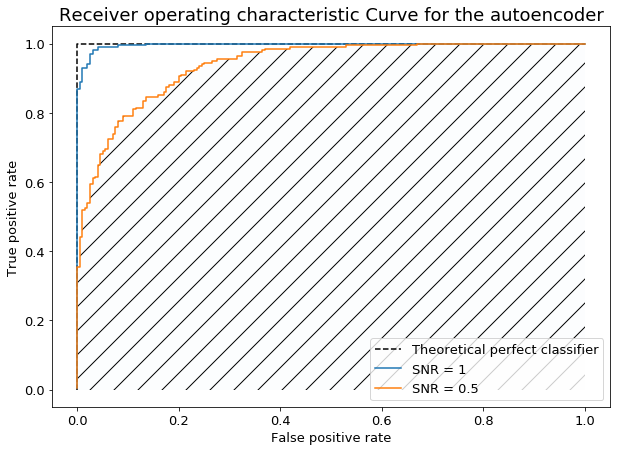

In [55]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import pickle 
scores1 = out_list[0]+out_list[1]
y1 = [0 for i in range(len(out_list[0]))]+[1 for i in range(len(out_list[1]))]
fpr1, tpr1, thresholds1 = roc_curve(y1, scores1, pos_label = 1)

aoc_snr1 = roc_auc_score(y1,scores1)
print(f"The aoc score is {aoc_snr1:.3f} for snr =1")

scores2 = out_list[0]+out_list[2]
y2 = [0 for i in range(len(out_list[0]))]+[1 for i in range(len(out_list[2]))]
fpr2, tpr2, thresholds2= roc_curve(y2, scores2, pos_label = 1)

aoc_snr2 = roc_auc_score(y2,scores2)
print(f"The aoc score is {aoc_snr2:.3f} for snr =0.5")

with open("auto_roc.txt", "wb") as f: 
    pickle.dump({"fpr1":fpr1, "tpr1":tpr1, "thresholds1":thresholds1,"fpr2":fpr2, "tpr2":tpr2, "thresholds2":thresholds2
                , "scores1": scores1, "scores2": scores2, "y1": y1, "y2":y2},f)

fig, ax = plt.subplots(1,1, figsize = (10,7))

ax.title.set_text("Receiver operating characteristic Curve for the autoencoder")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.plot(fpr1,[0]+[1 for i in range(len(fpr1)-1)],linestyle = "dashed", markersize = 7, label = "Theoretical perfect classifier", c = "black")

ax.plot(fpr1, tpr1, label = "SNR = 1")
ax.plot(fpr2, tpr2, label = "SNR = 0.5")
ax.fill_between(fpr2, tpr2, hatch = "/", alpha = 0.01)

ax.legend()

In [21]:
import librosa

test_piece, sr = librosa.load("./data/synthetic/7_with_void.wav")

score = []
i =0 
my_len = 16*512-1
while i<len(test_piece)-my_len:
    piece = test_piece[i:i+my_len]
    xt  = librosa.power_to_db(librosa.feature.melspectrogram(piece, n_mels = 128, fmax = 1024))
    xt = torch.tensor(xt).float()
    xt = torch.unsqueeze(xt,0)
    xt = torch.unsqueeze(xt,0)
    xt = xt.to(device)
    mu, logvar = E_module(xt)
    z = reparameterise(mu, logvar, False)

    out = G_module(z)        
    loss = mse_per_image(out, xt)
    
    score.append(float(torch.sum(loss.detach().cpu())/(xt.shape[-1]*xt.shape[-2])))
    i+= 512


## 11/03/2021

The performance is again visualised over the spectrogram. The VAE mdoel is shown to have a very much better performance in the region of t = 7.5. This region was confusing for the previous models and the fact that the vae model was able to not struggle with this region shows that the model is more suited to this application. 

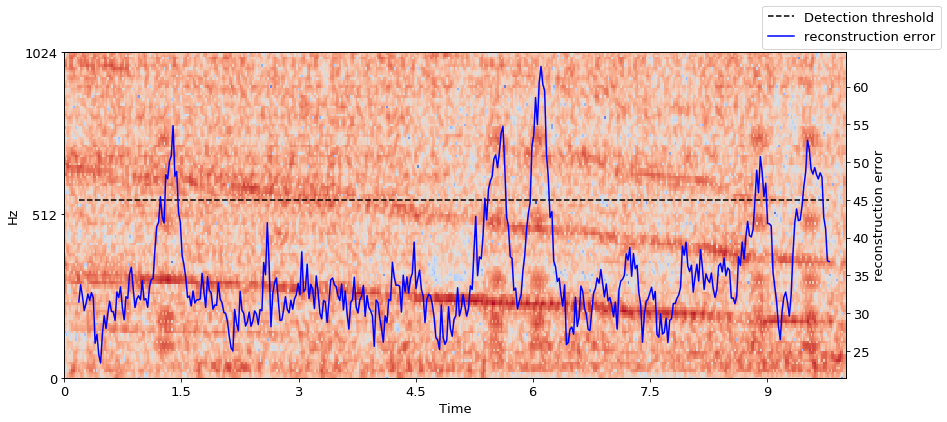

In [47]:
import librosa.display
x =[]
test_xt = librosa.power_to_db(librosa.feature.melspectrogram(test_piece, n_mels =128, fmax= 1024))
fig = plt.gcf()
fig.set_size_inches(14,6)
ax = plt.subplot()

ax2 = ax.twinx()
librosa.display.specshow(test_xt, fmax = 1024, y_axis = "mel", ax = ax, x_axis = 'time')
for i in range(len(score)):
    x.append((i+8)*(512/sr))
ax2.set_ylabel("reconstruction error")
ax2.plot(x,[45 for i in range(len(x))],linestyle = "dashed", markersize = 7, label = "Detection threshold", c = "black")
ax2.plot(x,score, c="blue", label = "reconstruction error")
fig.legend()

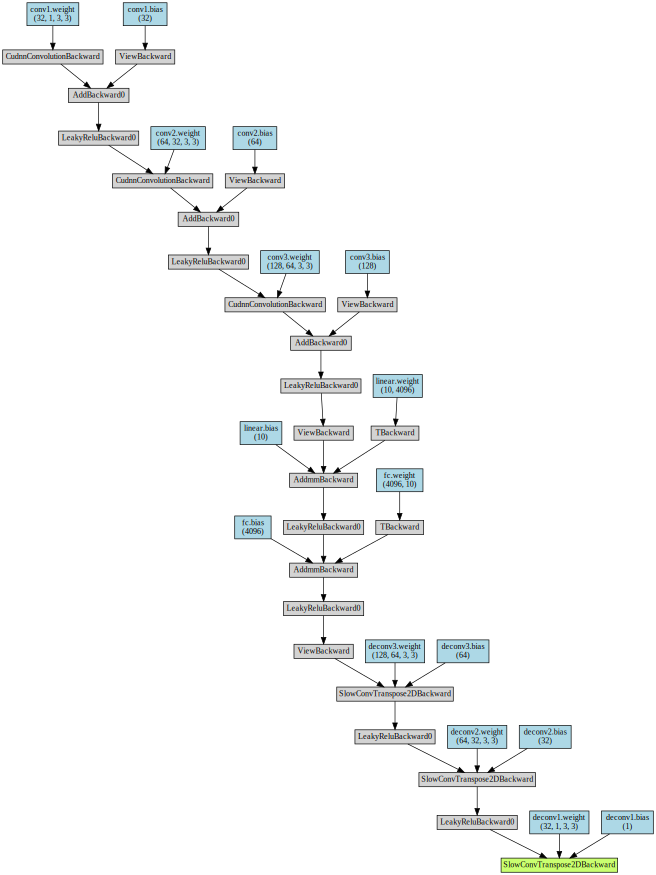

In [161]:
from torchviz import make_dot 
make_dot(recons, params = dict(autoencoder.named_parameters()))

In [163]:
from torch.utils.tensorboard import SummaryWriter 
writer = SummaryWriter("runs/ae_experiment_1")

In [169]:
writer.add_graph(autoencoder,images)


$$ z_i$$